# Contents
1. Introduction
2. Imports and Setup
3. Load Data
4. Sandbox
5. Explore and evaluate models
6. Optimize best model
7. Summary
8. Conclusion

# 1. Introduction

The data read into this notebook originates from the Cap2_preprocessing_and_data_development notebook located in the same directory as this one.

In this notebook, we will compare the performance of predicting the scoring spread of NFL games using 4 different modeling methods. Whlie treating the scoring spread outcome as a continuous variable, Random Forest Regressors and Linear Regressors will be applied and evaluated. Then while treating the scoring spread outcome as a boolean variable of "yes or no did the home team beat the spread", Random Forest Classifiers and Logistic regression models will both be applied and evaluatied.

# 2. Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve


# 3. Load data

In [3]:
main_df_numeric = pd.read_csv('./data/main_df_numeric')
df_in = main_df_numeric.drop(['Unnamed: 0.1','Unnamed: 0'], axis=1)

Data set for modeling reduced to include "modern" football only, as styles of gameplay and therefore scoring trends have changed over time. Modern era of 26 years chosen becuase the longest NFL player career ever was 26 seasons.

A holdout/validation set of 2022 data will be created, and model training and testing will depend only on 1996-2021 data.

In [4]:
df_modern = df_in[df_in.schedule_season > 1995]

val_holdout = df_modern[df_modern.schedule_season == 2022]
df = df_modern[df_modern.schedule_season != 2022]

df.head(3)

,schedule_season,schedule_week,schedule_playoff,over_under_line,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,home_pred_spread,home_ATS,...,away_WAS,weather_detail__fog,weather_detail__indoor,weather_detail__none,weather_detail__rain,weather_detail__rain | fog,weather_detail__retractable (open roof),weather_detail__snow,weather_detail__snow | Freezing rain,weather_detail__snow | fog
3779,1996,1,False,40.0,False,71.0,5.0,70.0,-1.0,4.0,...,False,False,False,True,False,False,False,False,False,False
3780,1996,1,False,41.0,False,72.0,6.0,65.0,3.0,26.0,...,False,False,False,True,False,False,False,False,False,False
3781,1996,1,False,42.0,False,74.0,14.0,30.0,-8.0,17.0,...,False,False,False,True,False,False,False,False,False,False


Create copy of df, but with home_ATS target variable as a discrete output df_tf

In [5]:
df_tf = df.copy()
df_tf['home_ATS'] = df.home_ATS > 0
df_tf.head();

df_modern_tf = df_modern.copy()
df_modern_tf['home_ATS'] = df_modern_tf.home_ATS > 0

# 4. Sandbox

## 4.1 How to manage training/test splits

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

<Axes: title={'center': 'Singular time-based Train/Test split'}>

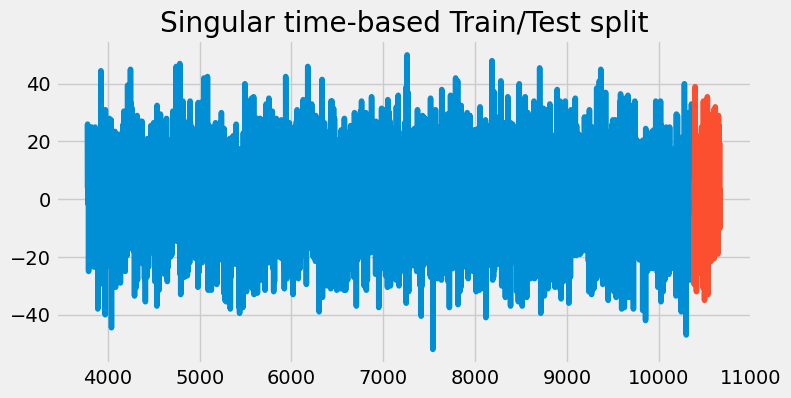

In [8]:
#Visualize standard cross validation
standard_train = df[df.schedule_season != 2021]
standard_test = df[df.schedule_season == 2021]

#visualize data split
fig, ax = plt.subplots(figsize=(8,4))
standard_train.home_ATS.plot(ax=ax, label='Training', title='Singular time-based Train/Test split', markersize=0.01)
standard_test.home_ATS.plot(ax=ax, label='Testing')

This plot shows a possible train/test split for time-dependent data, however to improve model efficacy we will aim to generate many smaller testing splits and iterate over them, the way this model would be applied on a weekly basis to predict NFL games after deployment.

##### Example from Youtube Rob Mulla
https://www.youtube.com/watch?v=z3ZnOW-S550

The following cell is a practice deployment of the TimeSeriesSplit function that will be used throughout this notebook in order to simulate training and testing models weekly across NFL seasons. For example, we will train on available data up through week 1 of the 2021 season, then use that trained model to predict week 2 only. This will be repeated for all test weeks.

In [9]:
#this code block commented out to save unneeded runtime when notebook is opened
'''

tss = TimeSeriesSplit(n_splits=3, test_size=16, gap=0)

fold=0
preds=[]
scores=[]

for train_idx, val_idx, in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    X_train = train.drop('home_ATS', axis=1)
    y_train = train.home_ATS
    
    X_test = test.drop('home_ATS', axis=1)
    y_test = test.home_ATS
    
    xg_mod = xgb.XGBRegressor(base_score = 0.5,
                             booster='gbtree',
                             n_estimators=1000, early_stopping_rounds=50,
                             objective='reg:linear', max_depth=3,
                             learning_rate=0.01)
    xg_mod.fit(X_train, y_train, 
              eval_set=[(X_train,y_train), (X_test,y_test)],
              verbose=500)
    
    y_pred = xg_mod.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    fold+=1
    
print(f'Avg RMSE score across folds {np.mean(scores):0.4f}')
print(f'Individual scores: {scores}')

''';

##### Template - to apply the above method to various future types of models.

In [10]:
#this code block commented out to save unneeded runtime when notebook is opened
'''

# Split Time-series-based Train and Test sets - may not need to be duplicated?
tss = TimeSeriesSplit(n_splits=34, test_size=16, gap=0)  #34 splits by 16 games represents two seasons

fold=0
preds=[]
scores=[]

for train_idx, val_idx, in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    X_train = train.drop('home_ATS', axis=1)
    y_train = train.home_ATS
    
    X_test = test.drop('home_ATS', axis=1)
    y_test = test.home_ATS
    
    #INSTANTIATE NEW MODEL HERE
    
    ###
    ###
    
    y_pred = ___.predict(X_test)
    preds.append(y_pred)
    score = mean_absolute_error(y_test, y_pred)
    scores.append(score)

    fold+=1
    
print(f'Avg MAE score across folds {np.mean(scores):0.4f}')
print(f'Median prediction percentiles: {np.percentile(preds, q=[0,25,50,75,100])}')
    
''';

# 5. Explore and Evaluate Models

## 5.1 Treating performance ATS as continuous

### 5.1.1 Random Forest Regressor

In [11]:
# Split Time-series-based Train and Test sets - may not need to be duplicated?
tss = TimeSeriesSplit(n_splits=34, test_size=16, gap=0)  #34 splits by 16 games represents roughly 2 seasons

fold=0
preds=[]
abs_scores=[]
y_test_bools = []
y_pred_bools = []

for train_idx, val_idx, in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    X_train = train.drop('home_ATS', axis=1)
    y_train = train.home_ATS
    
    X_test = test.drop('home_ATS', axis=1)
    y_test = test.home_ATS
    
    #INSTANTIATE NEW MODEL HERE
    
    rf_model = RandomForestRegressor(
            n_estimators=160,  # Number of trees in the forest
            max_depth=4,    # Maximum depth of the tree nodes
            min_samples_split=4,  # Minimum number of samples required to split an internal node
            max_features='log2',  
            random_state=42)

    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    preds.append(y_pred)
    
    abs_score = mean_absolute_error(y_test, y_pred)
    abs_scores.append(abs_score)
    
    #compare the sign (pos or neg) of y_test and y_pred
    for i in range(16):
        y_test_bools.append(y_test.iloc[i] > 0)
        y_pred_bools.append(y_pred[i] > 0)
    

    fold+=1
accuracy_rfr = accuracy_score(y_test_bools, y_pred_bools)

In [12]:
print(f'Avg MAE score across folds {np.mean(abs_scores):0.4f}')
print(f'Median prediction percentiles: {np.percentile(preds, q=[0,25,50,75,100])}')
print(f'Accuracy: {accuracy_rfr}')

Avg MAE score across folds 10.2288
Median prediction percentiles: [-1.3742803  -0.50105312 -0.30955622 -0.09337237  0.90116315]
Accuracy: 0.5441176470588235


#### RF Regressor Parameter Tuning

Note: this parameter tuning is located after the iterative time-based test splitting in this notebook, however in practice the resulting optimal values were added back to the above modeling.

In [13]:
#this code block commented out to save unneeded runtime when notebook is opened
'''
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': np.arange(10, 200, 10),           # Number of trees in the forest
    'max_depth': [None] + list(np.arange(2, 20)),    # Maximum depth of the tree nodes
    'min_samples_split': np.arange(2, 11),           # Minimum number of samples required to split an internal node
    'max_features': ['auto', 'sqrt', 'log2'],        # Number of features to consider when looking for the best split
    'random_state': [42]
    }

# Create the RandomForestRegressor model
rf_model = RandomForestRegressor()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_grid, n_iter=100, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1
)

# Fit the RandomizedSearchCV to the training data (from block above)
random_search.fit(X_train, y_train);

# Get the best hyperparameters from the search
best_params = random_search.best_params_
print("Best Hyperparameters:")
print(best_params)


# Evaluate the model with the best hyperparameters on the validation set
best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Calculate the root mean squared error as an evaluation metric
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean absolute Error on Test Data: {mae}")
''';

Output of above saved as text: 
Best Hyperparameters:
{'random_state': 42, 'n_estimators': 90, 'min_samples_split': 4, 'max_features': 'log2', 'max_depth': 4}

### 5.1.2 Linear Regression

In [14]:
# Split Time-series-based Train and Test sets - may not need to be duplicated?
tss = TimeSeriesSplit(n_splits=34, test_size=16, gap=0)  #34 splits by 16 games represents two seasons

fold=0
preds=[]
scores=[]
y_test_bools=[]
y_pred_bools=[]

for train_idx, val_idx, in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    X_train = train.drop('home_ATS', axis=1)
    y_train = train.home_ATS
    
    X_test = test.drop('home_ATS', axis=1)
    y_test = test.home_ATS
    
    #INSTANTIATE NEW MODEL HERE
    
    # Create the Linear Regression model
    lr_model = LinearRegression()

    # Fit the model to the training data
    lr_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lr_model.predict(X_test)

    preds.append(y_pred)
    score = mean_absolute_error(y_test, y_pred)
    scores.append(score)
    
    #compare the sign (pos or neg) of y_test and y_pred
    for i in range(16):
        y_test_bools.append(y_test.iloc[i] > 0)
        y_pred_bools.append(y_pred[i] > 0)
    

    fold+=1
accuracy_linreg = accuracy_score(y_test_bools, y_pred_bools)

In [15]:
print(f'Avg MAE score across folds for Linear Regression {np.mean(scores):0.4f}')
print(f'Accuracy: {accuracy_linreg}')

Avg MAE score across folds for Linear Regression 10.3606
Accuracy: 0.5110294117647058


## 5.2 Treating performance ATS as discrete

All of section 5.2 will be using tf_df as the input data, as it has the home_ATS column formatted as a true/false boolean of whether the home team is redicted to beat the spread or not.

### 5.2.1 Logistic regression

In [16]:
# Split Time-series-based Train and Test sets - may not need to be duplicated?
tss = TimeSeriesSplit(n_splits=34, test_size=16, gap=0)  #34 splits by 16 games represents two seasons

fold=0
preds=[]
accuracies=[]
y_tests=[]
y_preds=[]

for train_idx, val_idx, in tss.split(df_tf):
    train = df_tf.iloc[train_idx]
    test = df_tf.iloc[val_idx]
    
    X_train = train.drop('home_ATS', axis=1)
    y_train = train.home_ATS
    
    X_test = test.drop('home_ATS', axis=1)
    y_test = test.home_ATS
    
    #INSTANTIATE LogReg model
    
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    y_pred = logistic_model.predict(X_test)
    
    for i in range(16):
        y_tests.append(y_test.iloc[i])
        y_preds.append(y_pred[i])

    fold+=1
accuracy_logreg = accuracy_score(y_tests, y_preds)

In [17]:
print(f"Logistic Regression Model Accuracy {accuracy_logreg}")

Logistic Regression Model Accuracy 0.5238970588235294


### 5.2.2 Random Forest Classifier

In [18]:
# Split Time-series-based Train and Test sets - may not need to be duplicated?
tss = TimeSeriesSplit(n_splits=34, test_size=16, gap=0)  #34 splits by 16 games represents two seasons

fold=0
abs_scores=[]
y_tests=[]
y_preds=[]

for train_idx, val_idx, in tss.split(df_tf):
    train = df_tf.iloc[train_idx]
    test = df_tf.iloc[val_idx]
    
    X_train = train.drop('home_ATS', axis=1)
    y_train = train.home_ATS
    
    X_test = test.drop('home_ATS', axis=1)
    y_test = test.home_ATS
    
    #INSTANTIATE NEW MODEL HERE
    
    rf_model = RandomForestClassifier(
            n_estimators=20,  # Number of trees in the forest
            max_depth=4,    # Maximum depth of the tree nodes
            min_samples_split=3,  # Minimum number of samples required to split an internal node
            max_features='log2',  
            random_state=42)

    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    
    for i in range(16):
        y_tests.append(y_test.iloc[i])
        y_preds.append(y_pred[i])
        
    fold+=1
    
accuracy_rfc = accuracy_score(y_tests, y_preds)

In [19]:
print(f'Random Forest Classifier Accuracy: {accuracy_rfc}')

Random Forest Classifier Accuracy: 0.5514705882352942


Best Hyperparameters from executing the below, saved as text:
{'random_state': 42, 'n_estimators': 20, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': 4}

In [20]:
#this code block commented out to save unneeded runtime when notebook is opened
'''
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': np.arange(10, 200, 10),           # Number of trees in the forest
    'max_depth': [None] + list(np.arange(2, 20)),    # Maximum depth of the tree nodes
    'min_samples_split': np.arange(2, 11),           # Minimum number of samples required to split an internal node
    'max_features': ['auto', 'sqrt', 'log2'],        # Number of features to consider when looking for the best split
    'random_state': [42]
    }

# Create the RandomForestRegressor model
rf_model = RandomForestClassifier()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_grid, n_iter=100, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1
)

# Fit the RandomizedSearchCV to the training data (from last split above)
random_search.fit(X_train, y_train);

# Get the best hyperparameters from the search
best_params = random_search.best_params_
print("Best Hyperparameters:")
print(best_params)''';

# 6. Optimize Best Model

note to self: can we use confidence-based predictors? best 8 out of every batch of 16 etc.

##### Select model type from above

In [21]:
#Compare all model types applied above by accuracy score
print(f'Random Forest Regressor Accuracy: {accuracy_rfr}')
print(f'Linear Regressor Accuracy: {accuracy_linreg}')
print(f'Random Forest Classifier Accuracy: {accuracy_rfc}')
print(f'Logistic Regression Model Accuracy {accuracy_logreg}')

Random Forest Regressor Accuracy: 0.5441176470588235
Linear Regressor Accuracy: 0.5110294117647058
Random Forest Classifier Accuracy: 0.5514705882352942
Logistic Regression Model Accuracy 0.5238970588235294


Because it performed the best on initial modeling (55% accuracy score), we will move forward with the Random Forest Classifier model type and attempt to further optimize.

##### Test whether utilizing Predicted Probabilities from RFC can improve performance

In [22]:
# Split Time-series-based Train and Test sets - may not need to be duplicated?
tss = TimeSeriesSplit(n_splits=34, test_size=16, gap=0)  #34 splits by 16 games represents two seasons

fold=0
abs_scores=[]
y_tests=[]
y_preds=[]

for train_idx, val_idx, in tss.split(df_tf):
    train = df_tf.iloc[train_idx]
    test = df_tf.iloc[val_idx]
    
    X_train = train.drop('home_ATS', axis=1)
    y_train = train.home_ATS
    
    X_test = test.drop('home_ATS', axis=1)
    y_test = test.home_ATS
    
    
    rf_model = RandomForestClassifier(
            n_estimators=20,  # Number of trees in the forest
            max_depth=4,    # Maximum depth of the tree nodes
            min_samples_split=3,  # Minimum number of samples required to split an internal node
            max_features='log2',  
            random_state=42)

    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    y_proba = rf_model.predict_proba(X_test)
    
    #filter for where the probability from rf.predict_proba() is oredicted to be strong
    for i in range(16):
        if y_proba[i,1] > 0.525 or y_proba[i,1] < 0.475:   #bounds set to include roughly half of results aka choose a bet on half of all games
            y_tests.append(y_test.iloc[i])
            y_preds.append(y_pred[i])
        
    fold+=1
    
accuracy_rfc_prob = accuracy_score(y_tests, y_preds)

In [23]:
print(f'Accuracy score if we only predict the more confidently predicted games: {accuracy_rfc_prob}')
print(len(y_tests))

Accuracy score if we only predict the more confidently predicted games: 0.5461254612546126
271


In the above modeling, the prediction probabilities, aka prediction confidences, were used in an effort to optimize the model. In essence, only the strongest predictions were kept and used to predict games, effectively betting on the half of NFL games each week that the model is most confident about. This technique did NOT actually perform better than predicting every game.

## Test RF Classifier on 2022 validation set

In [24]:
# Split Time-series-based Train and Test sets - may not need to be duplicated?
tss = TimeSeriesSplit(n_splits=34, test_size=16, gap=0)  #34 splits by 16 games represents two seasons

fold=0
abs_scores=[]
y_tests=[]
y_preds=[]

for train_idx, val_idx, in tss.split(df_modern_tf):
    train = df_modern_tf.iloc[train_idx]
    test = df_modern_tf.iloc[val_idx]
    
    X_train = train.drop('home_ATS', axis=1)
    y_train = train.home_ATS
    
    X_test = test.drop('home_ATS', axis=1)
    y_test = test.home_ATS
    
    #INSTANTIATE NEW MODEL HERE
    
    rf_model = RandomForestClassifier(
            n_estimators=20,  # Number of trees in the forest
            max_depth=4,    # Maximum depth of the tree nodes
            min_samples_split=3,  # Minimum number of samples required to split an internal node
            max_features='log2',  
            random_state=42)

    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    
    for i in range(16):
        y_tests.append(y_test.iloc[i])
        y_preds.append(y_pred[i])
        
    fold+=1
    
accuracy_2022 = accuracy_score(y_tests, y_preds)

In [25]:
print(accuracy_2022)

0.5110294117647058


Confusion Matrix:
[[241  41]
 [225  37]]
Precision: 0.47
Recall: 0.14
AUC/ROC: 0.50


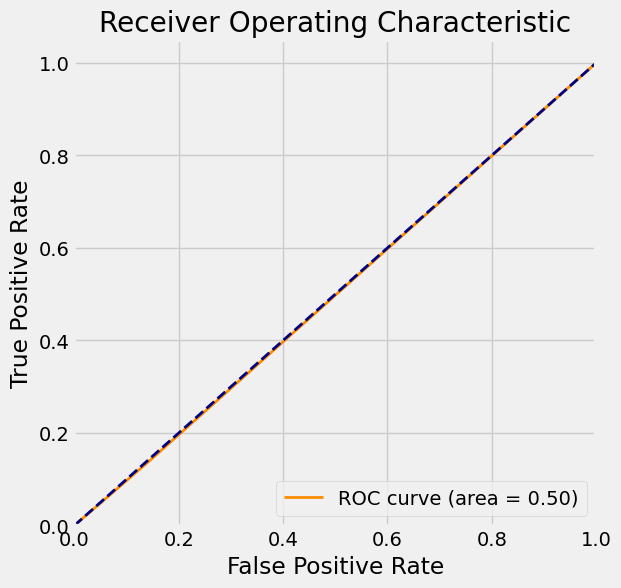

In [27]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_tests, y_preds)

# Calculate Precision
precision = precision_score(y_tests, y_preds)

# Calculate Recall
recall = recall_score(y_tests, y_preds)

# Calculate AUC/ROC
roc_auc = roc_auc_score(y_tests, y_preds)
fpr, tpr, _ = roc_curve(y_tests, y_preds)

# Print the metrics
print("Confusion Matrix:")
print(cm)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC/ROC: {roc_auc:.2f}")

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# 7. Summary

In this notebook, 4 different Machine Learning Models were applied to predict whether the home team of an NFL game would beat the betting spread.

After loading preprocessed data from notebook Cap2_preprocessing_and_data_development, a holdout/validation dataset of the most recent NFL season was set aside to be removed from training.
Copies of the dataframe were then made with the two different formats of the target varible home_ATS, continuous and boolean.

Some work was then done to experiment with different train/test splitting methods, and it was decided that TimeSeriesSplit would be used for further modeling testing.
Each of 4 model types were applied to the data and evaluated: Linear regression, logistic regression, Random forest classifier and random forest regressor. The Random Forest Classifier perfomed the best when trained and evaluated using all data excluding the holdout set, so it was then selected and applied to the validation data.

# 8. Conclusion

The leading modeling approach after initial testing, the Random Forest Classifier, scored poorly on the validation data (accuracy score of 0.51), which demonstrates that the model initially performing well may be the result of overfitting or random chance.

The target variable in this study, home_ATS, is a value that represents a home team's ability to beat the betting spread, which is inherently very complex to predict because it is a composite value not only of gae outcome, but also must consider the complexity of the sports books developing that pregame predicted betting spread in the first place.

It is not extremely surprising, then, that it proved challenging to develop a model to predict teams' performance against the spread using the relatively simple data used as input to this project. 

In a future attempt to predict games better than the sports book does, it may be valuable to include more sophisticated data such as:
- relative team health (injuries)
- skill/experience of important people like head coach or quarterback
- team style of play over time, like when new coaches bring a change in strategy

As part of a larger-scope project, I would also recommend testing more variety of model types and intensity of parameter tuning.



# References

Feature engineering for Time Series Forecasting. https://www.youtube.com/watch?v=9QtL7m3YS9I

Advanced time series Forecasting - XGboost example - Rob Mulla https://www.youtube.com/watch?v=z3ZnOW-S550